# CSC321H5 Project 2 - Multi-Layer Perceptron + Word Embeddings. Predict next word in a sentence

**Deadline**: Thursday, Feb. 13, by 9pm

**Submission**: Submit a PDF export of the completed notebook. 

# Submitted By:

*   Valerie June Loka (100 4900 495) lokavale
*   Gabrielle Ong (100 4634 791) onggabr1

**Late Submission**: Please see the syllabus for the late submission criteria.

Based on an assignment by George Dahl, Jing Yao Li, and Roger Grosse

In this assignment, we will make a neural network that can predict the next word
in a sentence given the previous three. 
We'll explore a couple of different models to perform this prediction task. We will also do this
problem twice: once in PyTorch, and once using numpy. When using numpy, you'll implement
the backpropagation computation.

In doing this prediction task, our neural networks will learn about *words* and about
how to represent words. We'll explore the *vector representations* of words that our
model produces, and analyze these representations.

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data

With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like. Download the file
`raw_sentences.txt` from `https://www.cs.toronto.edu/~lczhang/321/hw/raw_sentences.txt`
and upload it to Google Drive.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Find the path to `raw_sentences.txt`:

In [ ]:
file_path = 'gdrive/My Drive/Colab Notebooks/raw_sentences.txt'

You might find it helpful to know that you can run shell commands (like `ls`) by
using `!` in Google Colab, like this:

The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [ ]:
sentences = []

for line in open(file_path, 'r'):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

There are 97,162 sentences in total, and 
these sentences are composed of 250 distinct words.

In [ ]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 97162
print(len(vocab)) # 250

97162
250


We'll separate our data into training, validation, and test.
We'll use `10,000 sentences for test, 10,000 for validation, and
the rest for training.

In [ ]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

### Part (a) -- 2 pts

Display 10 sentences in the training set.
Explain how punctuations are treated in our word representation, and how words
with apostrophes are represented.

In [ ]:
# Your code goes here
print(sentences[:10])
'''
words with apostrophes are represented as 2 words,
the first being the portion before the apostrophy 
and the second being the apostrophy and the rest of the word after it.
punctuations are represented as a separate word itself altogether
'''
# output:
# [['no', ',', 'he', 'says', 'now', '.'], 
#  ['and', 'what', 'did', 'he', 'do', '?'],
#  ['the', 'money', "'s", 'there', '.'], 
#  ['that', 'was', 'less', 'than', 'a', 'year', 'ago', '.'], 
#  ['but', 'he', 'made', 'only', 'the', 'first', '.'], 
#  ['there', "'s", 'still', 'time', 'for', 'them', 'to', 'do', 'it', '.'], 
#  ['but', 'he', 'should', 'nt', 'have', '.'], 
#  ['they', 'have', 'to', 'come', 'down', 'to', 'the', 'people', '.'], 
#  ['i', 'do', 'nt', 'know', 'where', 'that', 'is', '.'], 
#  ['no', ',', 'i', 'would', 'nt', '.']]

[['no', ',', 'he', 'says', 'now', '.'], ['and', 'what', 'did', 'he', 'do', '?'], ['the', 'money', "'s", 'there', '.'], ['that', 'was', 'less', 'than', 'a', 'year', 'ago', '.'], ['but', 'he', 'made', 'only', 'the', 'first', '.'], ['there', "'s", 'still', 'time', 'for', 'them', 'to', 'do', 'it', '.'], ['but', 'he', 'should', 'nt', 'have', '.'], ['they', 'have', 'to', 'come', 'down', 'to', 'the', 'people', '.'], ['i', 'do', 'nt', 'know', 'where', 'that', 'is', '.'], ['no', ',', 'i', 'would', 'nt', '.']]


'\nwords with apostrophes are represented as 2 words,\nthe first being the portion before the apostrophy \nand the second being the apostrophy and the rest of the word after it.\npunctuations are represented as a separate word itself altogether\n'

### Part (b) -- 2 pts

What are the 10 most common words in the vocabulary? How often does each of these
words appear in the training sentences? Express the second quantity a percentage
(i.e. number of occurences of the  word / total number of words in the training set).

These are good quantities to compute, because one of the first things a machine learning
model will learn is to predict the **most common** class. Getting a sense of the
distribution of our data will help you understand our model's behaviour.

You can use Python's `collections.Counter` class if you would like to.

In [ ]:
# Your code goes here
import collections
punct_lst = ['.', ',', ';', ':', '!', '?']

words_list = []
for sen in sentences:
  for w in sen:
    if w in vocab and w not in punct_lst:
      words_list.append(w)
ten_most_common = collections.Counter(words_list).most_common(10)
print(ten_most_common)

# output: 
# [('it', 29200), ('i', 22267), ('do', 20245), ('to', 19537), ('nt', 16460), 
# ('the', 15939), ('that', 15795), ("'s", 15734), ('he', 15387), ('you', 12780)]

[('it', 29200), ('i', 22267), ('do', 20245), ('to', 19537), ('nt', 16460), ('the', 15939), ('that', 15795), ("'s", 15734), ('he', 15387), ('you', 12780)]


### Part (c) -- 4 pts

Complete the helper functions `convert_words_to_indices` and
`generate_4grams`, so that the function `process_data` will take a 
list of sentences (i.e. list of list of words), and generate an 
$$N \times 4$$ numpy matrix containing indices of 4 words that appear
next to each other. You can use the constances `vocab`, `vocab_itos`,
and `vocab_stoi` in your code.

In [ ]:
# A list of all the words in the data set. We will assign a unique 
# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))
# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'],
    ['other', 'one', 'since', 'yesterday'], ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """
    # Write your code here
    index_list = [] # this is the final answer
    for sen in sents: # a sublist
      index_sublist = []
      for word in sen: # a word in a sublist
        index_sublist.append(vocab_stoi[word])
      index_list.append(index_sublist)
    return index_list

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """

    # Write your code here
    final_lst = []
    
    for sub in seqs:
        for i in range(len(sub)):
            if i <= len(sub) - 4 and len(sub) >= 4: # check valid position of el
                final_lst.append(sub[i:i+4])
    return final_lst

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    (containing indices of 4 words that appear next to each other)
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

### DOC TESTS ###

print(convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'],
                                ['other', 'one', 'since', 'yesterday'], ['you']
                                ]))
print(generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
                      ))
print(generate_4grams([[1, 1, 1, 1, 1]]))
# output
#[[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
#[[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
#[[1, 1, 1, 1], [1, 1, 1, 1]]

[[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
[[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
[[1, 1, 1, 1], [1, 1, 1, 1]]


## Question 2. A Multi-Layer Perceptron

In this section, we will build a two-layer multi-layer perceptron.
We will first do this in numpy, and then once more in PyTorch.
Our model will look like this:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model1.png" />

Start by reviewing these helper functions, which are given to you:

In [ ]:
def make_onehot(indicies, total=250): 
  # spits out a 2D matrix of one-hot vectors (represented by the columns) of 
  # each word in the sentence, HENCE THE PARAM INDICES
    """
    Convert indicies into one-hot vectors by
        1. Creating an identity matrix of shape [total, total]
        2. Indexing the appropriate columns of that identity matrix
    """
    I = np.eye(total)
    return I[indicies]

def softmax(x):
    """
    Compute the softmax of vector x, or row-wise for a matrix x.
    We subtract x.max(axis=0) from each row for numerical stability.
    """
    x = x.T
    exps = np.exp(x - x.max(axis=0))
    probs = exps / np.sum(exps, axis=0)
    return probs.T

def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data in the form of 4-grams into input and output
    data and return the training data (xs, ts) where:
     - `xs` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `ts` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise

    Preconditions:
     - `data` is a numpy array of shape [N, 4] produced by a call
        to `process_data`
     - range_max > range_min
    """
    xs = data[range_min:range_max, :3]
    xs = make_onehot(xs)
    ts = data[range_min:range_max, 3]
    if onehot:
        ts = make_onehot(ts).reshape(-1, 250)
    return xs, ts

def estimate_accuracy(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        y = model(xs)
        pred = np.argmax(y, axis=1)
        correct += np.sum(ts == pred)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

### Part (a) -- 2 point

Your first task is to implement MLP model in Numpy.
This model is very similar to the one we built in Tutorial 5. However, we will
write our code differently from Tutorial 5, so that the class methods and APIs
are similar to that of PyTorch. This is to give you some intuition about what
PyTorch is doing under the hood.

We already wrote code for the backward pass for this model in Tutorial 5, so the
code is given to you. To make sure you understand how the model works, 
**write the code to compute the forward pass**.

In [ ]:
  class NumpyMLPModel(object):
    def __init__(self, num_features=250*3, num_hidden=400, num_classes=250):
        """
        Initialize the weights and biases of this two-layer MLP.
        """
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.weights1 = np.zeros([num_hidden, num_features])
        self.bias1 = np.zeros([num_hidden])
        self.weights2 = np.zeros([num_classes, num_hidden])
        self.bias2 = np.zeros([num_classes])
        self.cleanup()

    def initializeParams(self):
        """
        Initialize the weights and biases of this two-layer MLP to be random.
        This random initialization is necessary to break the symmetry in the
        gradient descent update for our hidden weights and biases. If all our
        weights were initialized to the same value, then their gradients will
        all be the same!
        """
        self.weights1 = np.random.normal(0, 2/self.num_features, 
                                         self.weights1.shape)
        self.bias1 = np.random.normal(0, 2/self.num_features, self.bias1.shape)
        self.weights2 = np.random.normal(0, 2/self.num_hidden, 
                                         self.weights2.shape)
        self.bias2 = np.random.normal(0, 2/self.num_hidden, self.bias2.shape)

    def forward(self, inputs):
        """
        Compute the forward pass prediction for inputs.
        Note that `inputs` will be a rank-3 numpy array with shape [N, 3, 250],
        so we will need to flatten the tensor to [N, 750] first.

        For the ReLU activation, you may find the function `np.maximum` helpful
        """
        X = inputs.reshape([-1, 750])

        # TODO:
        self.N = X.shape[0]
        self.X = X
        self.z1 = np.dot(self.X, self.weights1.T) + self.bias1
        self.h = np.maximum(self.z1, 0)
        self.z2 = np.dot(self.h, self.weights2.T) + self.bias2
        self.y = softmax(self.z2)
        return self.y

    def __call__(self, inputs):
        """
        To be compatible with PyTorch API. With this code, the following two
        calls are identical:

        >>> m = TwoLayerMLP()
        >>> m.forward(inputs)

        and 

        >>> m = TwoLayerMLP()
        >>> m(inputs)
        """
        return self.forward(inputs)

    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.
        Note that `ts` needs to be a rank 2 numpy array with shape [N, 250].
        """
        self.z2_bar = (self.y - ts) / self.N
        self.w2_bar = np.dot(self.z2_bar.T, self.h)
        self.b2_bar = np.dot(self.z2_bar.T, np.ones(self.N))
        self.h_bar = np.matmul(self.z2_bar, self.weights2)
        self.z1_bar = self.h_bar * (self.z1 > 0)
        self.w1_bar = np.dot(self.z1_bar.T, self.X)
        self.b1_bar = np.dot(self.z1_bar.T, np.ones(self.N))

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters.
        """
        self.weights1 = self.weights1 - alpha * self.w1_bar
        self.bias1    = self.bias1    - alpha * self.b1_bar
        self.weights2 = self.weights2 - alpha * self.w2_bar
        self.bias2    = self.bias2    - alpha * self.b2_bar

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
        """
        self.N = None
        self.X = None
        self.z1 = None
        self.h = None
        self.z2 = None
        self.y = None
        self.z2_bar = None
        self.w2_bar = None
        self.b2_bar = None
        self.h_bar = None
        self.z1_bar = None
        self.w1_bar = None
        self.b1_bar = None

### Part (b) -- 2 points

Complete the `run_gradient_descent` function. Train your numpy MLP model 
to obtain a training accuracy of at least 25%. You do not need to train
this model to convergence.

In [ ]:
def run_gradient_descent(model,
                         train_data=train4grams,
                         validation_data=valid4grams,
                         batch_size=100,
                         learning_rate=0.1,
                         max_iters=5000):
    """
    Use gradient descent to train the numpy model on the dataset train4grams.
    """
    n = 0
    while n < max_iters:
        # shuffle the training data, and break early if we don't have
        # enough data to remaining in the batch
        np.random.shuffle(train_data)
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i + batch_size, onehot=True)

            # forward pass: compute prediction
            # TODO: add your code here
            y = model.forward(xs)

            # backward pass: compute error 
            # TODO: add your code here
            model.backward(ts)
            model.update(learning_rate)
            # increment the iteration count
            n += 1

            # compute and plot the *validation* loss and accuracy
            if (n % 100 == 0):
                train_cost = -np.sum(ts * np.log(y)) / batch_size
                train_acc = estimate_accuracy(model, train_data)
                val_acc = estimate_accuracy(model, validation_data)
                model.cleanup() # prepares the model for the next set of inputs
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" 
                      % (n, val_acc * 100, train_acc * 100, train_cost))

            if n >= max_iters:
                return


numpy_mlp = NumpyMLPModel()
numpy_mlp.initializeParams()
run_gradient_descent(numpy_mlp)

Iter 100. [Val Acc 17%] [Train Acc 17%, Loss 5.159263]
Iter 200. [Val Acc 17%] [Train Acc 17%, Loss 4.838502]
Iter 300. [Val Acc 17%] [Train Acc 17%, Loss 4.769361]
Iter 400. [Val Acc 17%] [Train Acc 17%, Loss 4.500966]
Iter 500. [Val Acc 17%] [Train Acc 17%, Loss 4.355256]
Iter 600. [Val Acc 17%] [Train Acc 17%, Loss 4.232298]
Iter 700. [Val Acc 17%] [Train Acc 17%, Loss 4.690048]
Iter 800. [Val Acc 17%] [Train Acc 17%, Loss 4.268546]
Iter 900. [Val Acc 17%] [Train Acc 17%, Loss 4.265409]
Iter 1000. [Val Acc 17%] [Train Acc 17%, Loss 4.221031]
Iter 1100. [Val Acc 17%] [Train Acc 17%, Loss 4.123945]
Iter 1200. [Val Acc 17%] [Train Acc 17%, Loss 4.477267]
Iter 1300. [Val Acc 17%] [Train Acc 17%, Loss 4.351431]
Iter 1400. [Val Acc 17%] [Train Acc 18%, Loss 4.468817]
Iter 1500. [Val Acc 19%] [Train Acc 19%, Loss 4.107416]
Iter 1600. [Val Acc 19%] [Train Acc 19%, Loss 3.988546]
Iter 1700. [Val Acc 19%] [Train Acc 19%, Loss 4.363236]
Iter 1800. [Val Acc 19%] [Train Acc 19%, Loss 4.176730]
I

### Part (c) -- 2 pts

We will do build the same model in PyTorch. Since PyTorch uses automatic
differentiation, we only need to write the *forward pass* of our
model. Complete the `forward` function below:

In [ ]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_hidden=400):
        super(PyTorchMLP, self).__init__()
        self.layer1 = nn.Linear(750, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
        
    def forward(self, inp):
        inp = inp.reshape([-1, 750])
        # TODO: complete this function
        h = torch.relu(self.layer1(inp))
        return self.layer2(h)

### Part (d) -- 4 pts

We'll write similar code to train the PyTorch model. With a few differences:

1. We will use a slightly fancier optimizer called **Adam**. For this optimizer,
   a smaller learning rate usually works better, so the default learning
   rate is set to 0.001.
2. Since we get weight decay for free, you are welcome to use weight decay.

Complete the function `run_pytorch_gradient_descent`, and use it to train
your PyTorch MLP model to obtain a training accuracy of at least 38%.
Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.

In [ ]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        
        # forward pass prediction
        y = model(torch.Tensor(xs))
        y = y.detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(y, axis=1)
        correct += np.sum(pred == ts)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

def run_pytorch_gradient_descent(model,
                                 train_data=train4grams,
                                 validation_data=valid4grams,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=5000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/CSC321/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder CSC321, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/CSC321/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/CSC321/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/CSC321/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
    criterion = nn.CrossEntropyLoss() # performs softmax
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0 # the number of iterations
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i + batch_size, onehot=False)

            # convert from numpy arrays to PyTorch tensors
            xs = torch.Tensor(xs)
            ts = torch.Tensor(ts).long()

            zs = model(xs) # this does forward
            loss = criterion(zs, ts) # criterion performs softmax for us
            loss.backward()
            optimizer.step() # updates w and b
            optimizer.zero_grad() # clears gradents for the next batch, 
            # if not gradients get accumulated

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" 
                      % (n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1
            
            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs


def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Iter 0. [Val Acc 0%] [Train Acc 0%, Loss 5.528621]
Iter 500. [Val Acc 29%] [Train Acc 30%, Loss 3.014225]
Iter 1000. [Val Acc 31%] [Train Acc 33%, Loss 2.816281]
Iter 1500. [Val Acc 32%] [Train Acc 33%, Loss 2.978471]
Iter 2000. [Val Acc 34%] [Train Acc 34%, Loss 2.381459]
Iter 2500. [Val Acc 34%] [Train Acc 35%, Loss 3.214311]
Iter 3000. [Val Acc 35%] [Train Acc 35%, Loss 2.808010]
Iter 3500. [Val Acc 35%] [Train Acc 35%, Loss 2.912283]
Iter 4000. [Val Acc 35%] [Train Acc 36%, Loss 2.545719]
Iter 4500. [Val Acc 35%] [Train Acc 37%, Loss 2.688655]
Iter 5000. [Val Acc 35%] [Train Acc 37%, Loss 2.766499]
Iter 5500. [Val Acc 36%] [Train Acc 37%, Loss 2.697357]
Iter 6000. [Val Acc 36%] [Train Acc 37%, Loss 2.699950]
Iter 6500. [Val Acc 36%] [Train Acc 37%, Loss 2.418192]
Iter 7000. [Val Acc 36%] [Train Acc 37%, Loss 2.339251]
Iter 7500. [Val Acc 37%] [Train Acc 38%, Loss 2.741089]
Iter 8000. [Val Acc 37%] [Train Acc 39%, Loss 2.648784]
Iter 8500. [Val Acc 37%] [Train Acc 39%, Loss 2.450942

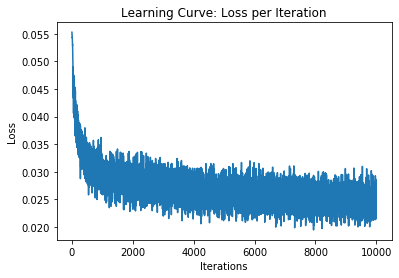

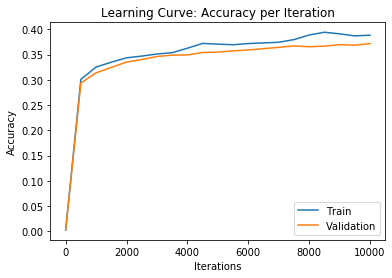

In [ ]:
import os 
pytorch_mlp = PyTorchMLP()
learning_curve_info = run_pytorch_gradient_descent(
      pytorch_mlp,
      max_iters = 10000,
      checkpoint_path='gdrive/My Drive/CSC321/proj2/pytorchmlp/ckpt-{}.pk')

# you might want to save the `learning_curve_info` somewhere, 
# so that you can plot the learning curve prior to exporting your PDF file
plot_learning_curve(*learning_curve_info)

### Part (e) -- 3 points

Write a function `make_prediction` that takes as parameters
a PyTorchMLP model and sentence (a list of words), and produces
a prediction for the next word in the sentence.

Start by thinking about what you need to do, step by step, taking
care of the difference between a numpy array and a PyTorch Tensor.

In [ ]:
def make_prediction_torch(model, sentence):
    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[:-3]). You may assume
    that len(sentence) >= 3 and that `model` is an instance of
    PYTorchMLP.

    This function should return the next word, represented as a string.

    Example call:
    >>> make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])
    """
    global vocab_stoi, vocab_itos

    last_3_words = sentence[-3:]
    indices = [vocab_stoi[word] for word in last_3_words]

    # get list of one-hot vectors from indices
    xs_numpy = make_onehot(indices) #[3,  250]

    # transform numpy array to pytorch tensor
    xs_torch = torch.Tensor(xs_numpy)

    # do a model forward pass on the input to get z
    y_torch = model(xs_torch)

    y_numpy = y_torch.detach().numpy()

    pred = np.argmax(y_numpy, axis=1)

    # get the string from index
    return vocab_itos[pred[0]]

### Part (f) -- 4 points

Use your code to predict what the next word should be in each
of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

Do your predictions make sense? (If all of your predictions are the same,
train your model for more iterations, or change the hyperparameters in your
model. You may need to do this even if your training accuracy is >=38%)

One concern you might have is that our model may be "memorizing" information
from the training set.  Check if each of 3-grams (the 3 words appearing next
to each other) appear in the training set. If so, what word occurs immediately
following those three words?

In [ ]:
print(make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])) # family
print(make_prediction_torch(pytorch_mlp, ['few', 'companies', 'show'])) # up
print(make_prediction_torch(pytorch_mlp, ['there', 'are', 'no'])) # other
print(make_prediction_torch(pytorch_mlp, ['yesterday', 'i', 'was'])) # nt
print(make_prediction_torch(pytorch_mlp, ['the', 'game', 'had'])) # to
print(make_prediction_torch(pytorch_mlp, ['yesterday', 'the', 'federal']))
#government

"""
[you are a] [family]
There are 17 occurences of this 3-grams in the training set. 
5/17 of them have 'good' as the next word.
2/17 have 'family' as the next word.
This shows that our model may by memorizing information,
but not simply the most common word that appears next to the 3 given words.

[few companies show] [up]
There are no occurences of this 3-grams in the training set.
There are 2 occurences of [few companies], where the next word was '.'
and 'still'.
There are 112 occurences of [show up],
which shows that it is a sensible prediction

[there are no] [other]
There are 8 occurences of [there are no] in the dataset, 
but 'other' wasn't followed after the 3-grams at all.
This is good as it shows that the model isn't overfitting and is training.

[yesterday i was] [nt]
There are no occurences of the 3-grams in the training set.
However, there are 947 occurences of [i was] and 139 occurences of [i was nt].
This is good because it shows that the model is actually being trained
and not overfitting on data.

[the game had] [to]
There are no occurences of [the game had] in the dataset, 
although there is 1 for [game had], and the word after it is 'come'. 
Since [to] is a reasonable predicted word for this 3-grams, this
shows that the model is actually being trained and learning.

[yestereday the federal] [government]
There are no occurences of the 3-grams in the training set.
However, there are 34 occurences of [the federal],
and 32 occurences of [the federal government]
This shows that the model is being trained properly,
and making 'logical' decisions despite the 3-grams not occuring in the dataset.
"""

family
up
other
nt
to
government


"\n[you are a] [good]\nThere are 17 occurences of this 3-grams in the training set. \n5/17 of them have 'good' as the next word.\n\n[few companies show] [.]\nThere are no occurences of this 3-grams in the training set.\nThere are 2 occurences of [few companies], where the next word was '.'\nand 'still'.\n\n[there are no] [other]\nThere are 8 occurences of [there are no] in the dataset, \nbut 'other' wasn't followed after the 3-grams at all.\nThis is good as it shows that the model isn't overfitting and is training.\n\n[yesterday i was] [nt]\nThere are no occurences of the 3-grams in the training set.\nHowever, there are 947 occurences of [i was] and 139 occurences of [i was nt].\nThis is good because it shows that the model is actually being trained\nand not overfitting on data.\n\nCHANGE THIS\n[the game had] [the]\nThere are no occurences of [the game had] in the dataset, \nalthough there is 1 for [game had], and the word after it is 'come'. \nSince 'the' is a reasonable predicted wor

### Part (g) -- 1 points

Report the test accuracy of your model

In [ ]:
# Write your code here
test_acc = estimate_accuracy_torch(pytorch_mlp, test4grams)
print("Test Acc %.0f%%" % ( test_acc * 100))

Test Acc 37%


## Question 3. Learning Word Embeddings

In this section, we will build a slightly different model with a different
architecture. In particular, we will first compute a lower-dimensional
*representation* of the three words, before using a multi-layer perceptron.

Our model will look like this:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model2.png" />

This model has 3 layers instead of 2, but the first layer of the network
is **not** fully-connected. Instead, we compute the representations of each
of the three words **separately**. In addition, the first layer of the network
will not use any biases. The reason for this will be clear in question 4.

### Part (a) - 10 pts

Complete the methods in `NumpyWordEmbModel`.

In [ ]:
class NumpyWordEmbModel(object):
    def __init__(self, vocab_size=250, emb_size=100, num_hidden=100):
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.num_hidden = num_hidden
        self.emb_weights = np.zeros([emb_size, vocab_size]) # (100, 250)
        self.weights1 = np.zeros([num_hidden, emb_size * 3])
        self.bias1 = np.zeros([num_hidden])
        self.weights2 = np.zeros([vocab_size, num_hidden])
        self.bias2 = np.zeros([vocab_size])
        self.cleanup()

    def initializeParams(self):
        """
        Randomly initialize the weights and biases of this two-layer MLP.
        The randomization is necessary so that each weight is updated to
        a different value.
        """
        self.emb_weights = np.random.normal(0, 2/self.num_hidden,
                                            self.emb_weights.shape)
        self.weights1 = np.random.normal(0, 2/self.emb_size*3,
                                         self.weights1.shape)
        self.bias1 = np.random.normal(0, 2/self.emb_size*3,
                                      self.bias1.shape)
        self.weights2 = np.random.normal(0, 2/self.num_hidden,
                                         self.weights2.shape)
        self.bias2 = np.random.normal(0, 2/self.num_hidden, self.bias2.shape)

    def forward(self, inputs):
        """
        Compute the forward pass prediction for inputs.
        Note that `inputs` will be a rank-3 numpy array with shape [N, 3, 250].

        For numerical stability reasons, we **do not** apply the softmax
        activation in the forward function. The loss function assumes that 
        we return the logits from this function.
        """

        # inputs are already one hot vectors. size [N, 3, 250]
        # if it were a 3d array, x = # of samples N, y is the words (out of 3) 
        # and z is the number of vocab ie features = 250
        
        # we want to apply the weights [100, 250] * Note: no biases!
        # onto each word (ie y = 0, 1, 2) for all samples 
        # to get [N, 100]

        # Get the the first words, second words and third words for all samples
        self.i0 = inputs[:, 0, :] # [N, 250]
        self.i1 = inputs[:, 1, :]
        self.i2 = inputs[:, 2, :]

        # apply the emb_weights for each i1 i2 i3
        # [N, 250] [100, 250] -> [N, 100]
        self.r0 = np.dot(self.i0, self.emb_weights.T)
        self.r1 = np.dot(self.i1, self.emb_weights.T) 
        self.r2 = np.dot(self.i2, self.emb_weights.T) 

        # # and then concatenate the word representations
        # ie 3 x [N, 100] -> [N, 300]
        self.r = np.concatenate((self.r0, self.r1, self.r2), axis=1) # [N, 300]

        # the rest is the same as before! 
        # X = [N, 300], W1 = (100, 300) , z1 = x.Wt + b = [N, 100]
        self.N = self.r.shape[0]
        self.X = self.r
        self.z1 = np.dot(self.X, self.weights1.T) + self.bias1

        self.h = np.maximum(self.z1, 0)
        self.z2 = np.dot(self.h, self.weights2.T) + self.bias2
        self.y = softmax(self.z2)
        return self.y

    def __call__(self, inputs):
        return self.forward(inputs)

    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.
        Note that `ts` needs to be a rank 2 numpy array with shape [N, 250].

        Remember the multivariate chain rule: if a weight affects the loss
        through different paths, then the error signal from all the paths
        must be added together.
        """
        self.z2_bar = (self.y - ts) / self.N
        self.w2_bar = np.dot(self.z2_bar.T, self.h)
        self.b2_bar = np.dot(self.z2_bar.T, np.ones(self.N))
        self.h_bar = np.matmul(self.z2_bar, self.weights2)
        self.z1_bar = self.h_bar * (self.z1 > 0)
        self.w1_bar = np.dot(self.z1_bar.T, self.X)
        self.b1_bar = np.dot(self.z1_bar.T, np.ones(self.N))
        self.r_bar = np.dot(self.z1_bar, self.weights1)

        self.r_bar0 = self.r_bar[: , :100]
        self.r_bar1 = self.r_bar[: , 100:200] 
        self.r_bar2 = self.r_bar[: , 200:300]
        self.w_emb_bar = np.dot(self.r_bar0.T, self.i0) + \
                        np.dot(self.r_bar1.T, self.i1) + \
                        np.dot(self.r_bar2.T, self.i2)

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters.
        """
        self.emb_weights = self.emb_weights - alpha * self.w_emb_bar
        self.weights1 = self.weights1 - alpha * self.w1_bar
        self.bias1    = self.bias1    - alpha * self.b1_bar
        self.weights2 = self.weights2 - alpha * self.w2_bar
        self.bias2    = self.bias2    - alpha * self.b2_bar

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
        """
        self.i0 = None
        self.i1 = None
        self.i2 = None
        self.r0 = None
        self.r1 = None
        self.r2 = None
        self.r = None
        self.N = None
        self.X = None
        self.z1 = None
        self.h = None
        self.z2 = None
        self.y = None

        self.r_bar = None
        self.r_bar0 = None
        self.r_bar1 = None
        self.r_bar2 = None
        self.w_emb_bar = None
        self.z2_bar = None
        self.w2_bar = None
        self.b2_bar = None
        self.h_bar = None
        self.z1_bar = None
        self.w1_bar = None
        self.b1_bar = None

### Part (b) -- 1 pts

One strategy that machine learning practitioners use to debug their code
is to *first try to overfit their model to a small training set*. If the
gradient computation is correct and the data is encoded properly, then your
model should easily achieve 100% training accuracy on a small training set.

Show that your model is implemented correctly by showing that your model
can achieve an 100% training accuracy within a few hundred iterations, when
using a small training set (e.g. one batch).

In [ ]:
numpy_wordemb = NumpyWordEmbModel()
numpy_wordemb.initializeParams()
run_gradient_descent(numpy_wordemb, train4grams[:64], batch_size=64)

Iter 100. [Val Acc 17%] [Train Acc 19%, Loss 4.524473]
Iter 200. [Val Acc 17%] [Train Acc 19%, Loss 3.697953]
Iter 300. [Val Acc 17%] [Train Acc 20%, Loss 3.300375]
Iter 400. [Val Acc 19%] [Train Acc 25%, Loss 2.897899]
Iter 500. [Val Acc 12%] [Train Acc 39%, Loss 2.394347]
Iter 600. [Val Acc 10%] [Train Acc 56%, Loss 1.887895]
Iter 700. [Val Acc 9%] [Train Acc 69%, Loss 1.397091]
Iter 800. [Val Acc 9%] [Train Acc 92%, Loss 0.928806]
Iter 900. [Val Acc 8%] [Train Acc 100%, Loss 0.558888]
Iter 1000. [Val Acc 8%] [Train Acc 100%, Loss 0.319031]
Iter 1100. [Val Acc 7%] [Train Acc 100%, Loss 0.187457]
Iter 1200. [Val Acc 7%] [Train Acc 100%, Loss 0.117036]
Iter 1300. [Val Acc 7%] [Train Acc 100%, Loss 0.077712]
Iter 1400. [Val Acc 7%] [Train Acc 100%, Loss 0.054787]
Iter 1500. [Val Acc 7%] [Train Acc 100%, Loss 0.040803]
Iter 1600. [Val Acc 7%] [Train Acc 100%, Loss 0.031867]
Iter 1700. [Val Acc 7%] [Train Acc 100%, Loss 0.025805]
Iter 1800. [Val Acc 7%] [Train Acc 100%, Loss 0.021492]
Ite

### Part (c) -- 2 pts

Train your model from part (a) to obtain a training accuracy of at least 25%.

In [ ]:
numpy_wordemb = NumpyWordEmbModel()
numpy_wordemb.initializeParams()
run_gradient_descent(numpy_wordemb)

Iter 100. [Val Acc 17%] [Train Acc 17%, Loss 5.032502]
Iter 200. [Val Acc 17%] [Train Acc 17%, Loss 4.880606]
Iter 300. [Val Acc 17%] [Train Acc 17%, Loss 4.554912]
Iter 400. [Val Acc 17%] [Train Acc 17%, Loss 4.384695]
Iter 500. [Val Acc 17%] [Train Acc 17%, Loss 4.528577]
Iter 600. [Val Acc 17%] [Train Acc 17%, Loss 4.188093]
Iter 700. [Val Acc 17%] [Train Acc 17%, Loss 4.103424]
Iter 800. [Val Acc 17%] [Train Acc 17%, Loss 4.353946]
Iter 900. [Val Acc 17%] [Train Acc 17%, Loss 4.194991]
Iter 1000. [Val Acc 17%] [Train Acc 17%, Loss 4.525984]
Iter 1100. [Val Acc 18%] [Train Acc 18%, Loss 4.301158]
Iter 1200. [Val Acc 20%] [Train Acc 20%, Loss 4.414664]
Iter 1300. [Val Acc 20%] [Train Acc 20%, Loss 4.092358]
Iter 1400. [Val Acc 20%] [Train Acc 20%, Loss 4.265350]
Iter 1500. [Val Acc 20%] [Train Acc 20%, Loss 4.140090]
Iter 1600. [Val Acc 20%] [Train Acc 21%, Loss 4.034623]
Iter 1700. [Val Acc 21%] [Train Acc 21%, Loss 4.043178]
Iter 1800. [Val Acc 21%] [Train Acc 21%, Loss 4.052192]
I

### Part (d) -- 2 pts

The PyTorch version of the model is implemented for you. Use 
`run_pytorch_gradient_descent` to train
your PyTorch MLP model to obtain a training accuracy of at least 38%.
Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.

Make sure that you checkpoint frequently. We will be using ...

Iter 0. [Val Acc 1%] [Train Acc 1%, Loss 5.530123]
Iter 500. [Val Acc 27%] [Train Acc 27%, Loss 3.271891]
Iter 1000. [Val Acc 29%] [Train Acc 29%, Loss 3.043026]
Iter 1500. [Val Acc 31%] [Train Acc 31%, Loss 3.182435]
Iter 2000. [Val Acc 32%] [Train Acc 32%, Loss 2.485475]
Iter 2500. [Val Acc 32%] [Train Acc 33%, Loss 3.313962]
Iter 3000. [Val Acc 33%] [Train Acc 33%, Loss 2.886694]
Iter 3500. [Val Acc 34%] [Train Acc 34%, Loss 2.922252]
Iter 4000. [Val Acc 34%] [Train Acc 34%, Loss 2.702659]
Iter 4500. [Val Acc 34%] [Train Acc 35%, Loss 2.848837]
Iter 5000. [Val Acc 34%] [Train Acc 35%, Loss 2.795928]
Iter 5500. [Val Acc 34%] [Train Acc 35%, Loss 2.906312]
Iter 6000. [Val Acc 35%] [Train Acc 35%, Loss 2.845852]
Iter 6500. [Val Acc 35%] [Train Acc 35%, Loss 2.541389]
Iter 7000. [Val Acc 35%] [Train Acc 36%, Loss 2.502887]
Iter 7500. [Val Acc 35%] [Train Acc 36%, Loss 2.898102]
Iter 8000. [Val Acc 35%] [Train Acc 37%, Loss 2.747041]
Iter 8500. [Val Acc 36%] [Train Acc 37%, Loss 2.384128

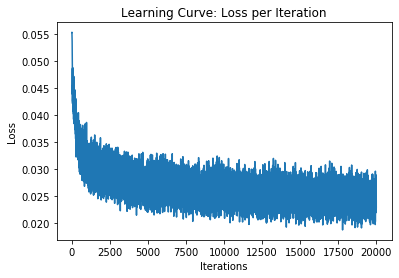

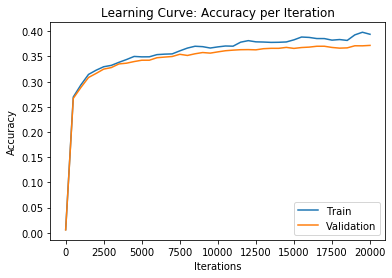

In [ ]:
class PyTorchWordEmb(nn.Module):
    def __init__(self, emb_size=100, num_hidden=300, vocab_size=250):
        super(PyTorchWordEmb, self).__init__()
        self.word_emb_layer = nn.Linear(vocab_size, emb_size, bias=False)
        self.fc_layer1 = nn.Linear(emb_size * 3, num_hidden)
        self.fc_layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
        self.emb_size = emb_size
        
    def forward(self, inp):
        embeddings = torch.relu(self.word_emb_layer(inp))
        embeddings = embeddings.reshape([-1, self.emb_size * 3])
        hidden = torch.relu(self.fc_layer1(embeddings))
        return self.fc_layer2(hidden)

pytorch_wordemb= PyTorchWordEmb()
result = run_pytorch_gradient_descent(pytorch_wordemb,
                                      max_iters=20000,
                                      checkpoint_path=
                      'gdrive/My Drive/CSC321/proj2/pytorch_wordemb/ckpt-{}.pk')

plot_learning_curve(*result)

### Part (e) -- 2 pts

Use the function `make_prediction` that you wrote earlier to  
predict what the next word should be in each of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

How do these predictions compared to the previous model?

Just like before, if all of your predictions are the same,
train your model for more iterations, or change the hyperparameters in your
model. You may need to do this even if your training accuracy is >=38%.

In [ ]:
print(make_prediction_torch(pytorch_wordemb, ['you', 'are', 'a'])) # good
print(make_prediction_torch(pytorch_wordemb, ['few', 'companies', 'show'])) # .
print(make_prediction_torch(pytorch_wordemb, ['there', 'are', 'no'])) # way
print(make_prediction_torch(pytorch_wordemb, ['yesterday', 'i', 'was'])) # .
print(make_prediction_torch(pytorch_wordemb, ['the', 'game', 'had'])) # to
print(make_prediction_torch(pytorch_wordemb, ['yesterday', 'the', 'federal'])) 
# government

"""
Previous Model's predictions:
[you are a] [family]
[few companies show] [up]
[there are no] [other]
[yesterday i was] [nt]
[the game had] [to]
[yesterday the federal] [government]


Compared to the previous model's predictions, 4 are different:
[you are a] [good]
[few companies show] [.]
[there are no] [way]
[yesterday i was] [.]

This model seems to return more period punctuations that we would like.
"""

good
.
way
.
to
government


"\nPrevious Model's predictions:\n[you are a] [family]\n[few companies show] [up]\n[there are no] [other]\n[yesterday i was] [nt]\n[the game had] [to]\n[yesterday the federal] [government]\n\n\nCompared to the previous model's predictions, 4 are different:\n[you are a] [good]\n[few companies show] [.]\n[there are no] [way]\n[yesterday i was] [.]\n\nThis model seems to return more period punctuations that we would like.\n"

### Part (f) -- 1 pts

Report the test accuracy of your model

In [ ]:
test_acc = estimate_accuracy_torch(pytorch_wordemb, test4grams)
print("Test Acc %.0f%%" % ( test_acc * 100))

Test Acc 38%


## Question 4. Visualizing Word Embeddings

While training the `PyTorchMLP`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. In this question, we will explore these word embeddings.

### Part (a) -- 2 pts

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.
Explain why each *row* of `word_emb` contains the vector representing
of a word. For example `word_emb[vocab_stoi["any"],:]` contains the
vector representation of the word "any".

In [ ]:
word_emb_weights = list(pytorch_wordemb.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T

# Write your explanation here
""" 
We get the word representation of a word by multiplying 
its one-hot vector and the embeded weights for that word.

From the initializer of the pytorch_wordemb model,
the shape of word_emb_weights is [vocab_size, emb_size] = [250, 100]
This means that each row contain the weights for a word.

Dimensions wise:
the shapes of word_emb_weights and word_emb, W, are both [250, 100]
the shape of the one hot vector of 1 word, X, is [1, 250]
X(W.T) give a vector of [1, 100] which is the vector representation of the word.

Code wise:
We get the index of a given word, i, using vocab_stoi["any"]
Since the one hot vector only has 1 at index i,
The matrix multiplication of X(W.T) will only return row i of word_emb, ie
word_emb[i, :]. Its shape is [1, 100] which confirms our intuition above.
Therefore, word_emb[i,:] gives us the vector word representation of the word.
"""

' \nWe get the word representation of a word by multiplying \nits one-hot vector and the embeded weights for that word.\n\nFrom the initializer of the pytorch_wordemb model,\nthe shape of word_emb_weights is [vocab_size, emb_size] = [250, 100]\nThis means that each row contain the weights for a word.\n\nDimensions wise:\nthe shapes of word_emb_weights and word_emb, W, are both [250, 100]\nthe shape of the one hot vector of 1 word, X, is [1, 250]\nX(W.T) give a vector of [1, 100] which is the vector representation of the word.\n\nCode wise:\nWe get the index of a given word, i, using vocab_stoi["any"]\nSince the one hot vector only has 1 at index i,\nThe matrix multiplication of X(W.T) will only return row i of word_emb, ie\nword_emb[i, :]. Its shape is [1, 100] which confirms our intuition above.\nTherefore, word_emb[i,:] gives us the vector word representation of the word.\n'

### Part (b) -- 2 pts

Once interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
we have provided code below that computes the cosine similarity of
every pair of words in our vocabulary. This code should look familiar,
since we have seen it in project 1.

In [ ]:
norms = np.linalg.norm(word_emb, axis=1)
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

# output
# 0.13677008
# -0.00672679

0.13677008
-0.00672679


Compute the 5 closest words to the following words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

In [ ]:
def get_nearest_neighbours(word, k=5):
  """Return the indices of the top k-element of `xs` that are closests to
  element `i` of the validation set `val_xs`.
  """
  # sort the element of the training set by distance to the i-th
  # element of val_xs
  neighbours = sorted(enumerate(similarities[:, vocab_stoi[word]]),
                      key=lambda r: r[1],
                      reverse=True)
  # obtain the top k closest index and return it
  neighbour_indices = [index for (index, dist) in neighbours[:k]]
  neighbour_words = [vocab_itos[i] for i in neighbour_indices]
  return neighbour_words

print(get_nearest_neighbours('four'))
print(get_nearest_neighbours('go'))
print(get_nearest_neighbours('what'))
print(get_nearest_neighbours('should'))
print(get_nearest_neighbours('school'))
print(get_nearest_neighbours('your'))
print(get_nearest_neighbours('yesterday'))
print(get_nearest_neighbours('not'))

# output: nearest word should be the word itself
# ['four', 'two', 'three', 'five', 'several']
# ['go', 'come', 'going', 'up', 'second']
# ['what', 'where', 'who', 'how', 'much']
# ['should', 'would', 'might', 'can', 'could']
# ['school', 'time', 'law', 'states', 'over']
# ['your', 'their', 'our', 'his', 'my']
# ['yesterday', 'week', 'season', 'first', 'next']
# ['not', 'nt', 'may', 'against', 'case']

['four', 'five', 'were', 'court', 'some']
['go', 'back', 'come', 'get', 'going']
['what', 'where', 'while', 'how', 'who']
['should', 'would', 'could', 'may', 'can']
['school', 'life', 'next', 'women', 'part']
['your', 'my', 'her', 'our', 'the']
['yesterday', 'general', 'then', 'one', 'us']
['not', 'nt', 'even', 'also', 'federal']


### Part (c) -- 2 pts

We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
(You don’t need to know what this is for the assignment,
but we may cover it later in the course.)
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.
Look at the plot and find two clusters of related words.
What do the words in each cluster have in common?

Note that there is randomness in the initialization of the t-SNE 
algorithm. If you re-run this code, you may get a different image.
Please make sure to submit your image in the PDF file for your TA to see.

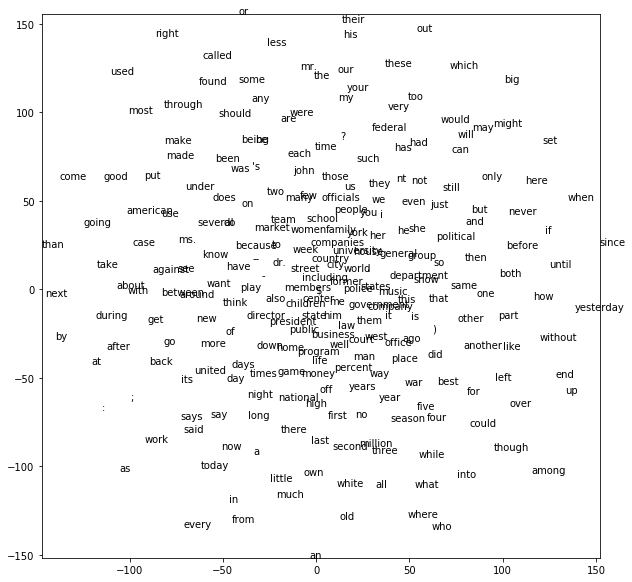

In [ ]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

"""
the 2 clusters we found are: 
cluster1 = [him, director, president, state,law, public, business],
which are entities related to roles of governance,
and reveals a bias in the data that it relates roles of governance to males

cluster2 = [women, family, school, market]
are entities that that have stereotypically related to societal roles of women
"""